# Hometask. Pyramid blending.

Input: two aligned images and mask
- Prepare Gaussian pyramid (sequence of blurred images)
- Based on Gaussian pyramid prepare Laplacian pyramid which is the difference between images of Gaussian pyramid
- Add last image from Gaussian pyramid to Laplacian
- Wrap Laplacian pyramid with mask for two images and deconstruct the pyramid to obtain result

### Includes:
 - CV solution
 - Numpy only solution
 
Remarks for numpy version: 
    - We loose a little bit of sharpeness in the process (not sure why) 
    - The blending acutally looks better than the cv version if we ignore the sharpness

In [254]:
import numpy as np
import imageio
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import scipy.stats  as st

In [255]:
# load and cut
pics = []
for image_path in glob.glob("*.jpg"):
    image = imageio.imread(image_path)
    image = image[:640,:640,:640]
    pics.append(np.transpose(image))

In [256]:
def display(image):
    image = np.swapaxes(image,0,2)
    plt.imshow(image)
    print(image.shape)
    plt.show()

(640, 640, 3)


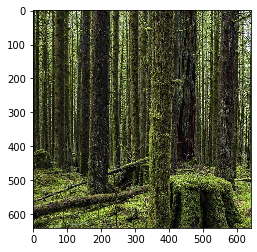

(640, 640, 3)


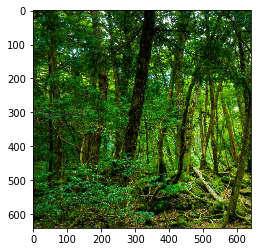

In [277]:
display(pics[0])
display(pics[1])

# Open CV implementation: 

In [257]:
A = pics[0].T
B = pics[1].T

In [258]:
def gaussian_pyramid(picture,height):
    pyramid = [picture]
    current = picture
    for x in range(height):
        current = cv2.pyrDown(current)
        pyramid.append(current)
    return pyramid

In [259]:
def laplacian_pyramid(gaussian):
    pyramid = [gaussian[-1]]
    for x in range(len(gaussian)-1,0,-1):
        current = cv2.pyrUp(gaussian[x])
        layer = cv2.subtract(gaussian[x-1],current)
        pyramid.append(layer)
    return pyramid       

In [260]:
def stack_lp(p1,p2):
    stack = []
    assert(len(p1) == len(p2))
    for x in range( len(p1)):
        size = p1[x].shape[0]
        new = np.hstack((p1[x][:,int(size/2):],p2[x][:,int(size/2):]))
        stack.append(new)
    return stack

In [261]:
def reconstruct(merge):
    current = merge[0]
    for x in range(1,len(merge)):
        current = cv2.pyrUp(current)
        current = cv2.add(current, merge[x])
    return current

In [262]:
g1 = (gaussian_pyramid(A,6))
g2 = (gaussian_pyramid(B,6))

In [263]:
lap1 = (laplacian_pyramid(g1))
lap2 = (laplacian_pyramid(g2))

In [264]:
lp_merg = stack_lp(lap1,lap2)

(640, 640, 3)


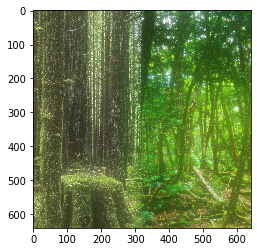

In [265]:
final = reconstruct(lp_merg)
display(final.T)

(640, 640, 3)


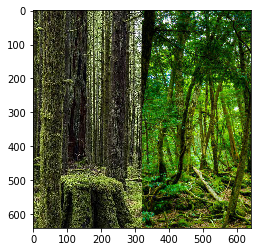

In [266]:
without_filter = np.hstack((A[:,int(320):],B[:,int(320):]))
display(without_filter.T)

# Numpy implementation

In [187]:
def downsample(img,width):
    img = img.T
    downImg = []
    for color in img: 
        newR = []
        newC = []    
        for y in range(0,len(color),width):
            newR.append(color[y])
        for row in newR: 
            half = []
            for z in range(len(row)):
                if z%width == 0: 
                    half.append(row[z])
            newC.append(half)
        downImg.append(newC)
    return np.array(downImg).T

In [188]:
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

In [232]:
def gaussian_blurr(pic,size=3,std=1):
    gfilter = gkern(size,std)
    final = []
    for color in pic:
        new = np.zeros((len(color),len(color)))
        for x in range(len(color)):
            for y in range(len(color)):
                a = color[x:x+size,y:y+size]
                if (a.shape[0] != size or a.shape[1] != size):
                    new[x][y] = np.average(a)
                else:
                    new[x][y] = np.sum(np.multiply(color[x:x+size,y:y+size],gfilter))
        final.append(new)
    final = np.array(final)
    final = final.astype("int")
    return final.T

In [233]:
def upsample_fill(img,width):
    img = img.T
    upImg = []
    for color in img: 
        newR = []
        newC = []
        for row in color: 
            half = []
            for z in range(len(row)):
                    half.append(row[z])
                    for w in range(width-1):
                        half.append(row[z])
            newC.append(half)
        for y in range(0,len(color)):
            newR.append(newC[y])
            for v in range(width-1):
                newR.append(newC[y])
        upImg.append(newR)
        
    upImg = np.array(upImg).T
    return upImg

In [234]:
def upsample_zero(img,width):
    img = img.T
    upImg = []
    for color in img: 
        newR = []
        newC = []
        for row in color: 
            half = []
            for z in range(len(row)):
                    half.append(row[z])
                    for w in range(width-1):
                        half.append(255)
            newC.append(half)
        for y in range(0,len(color)):
            newR.append(newC[y])
            for v in range(width-1):
                newR.append([255]*len(color[0])*width)
        upImg.append(newR)
        
    upImg = np.array(upImg)
    return np.array(upImg).T

In [235]:
def gaussian_pyramid(image,height):
    pyramid = [image.T]
    current = image.T
    for x in range(height):
        current = gaussian_blurr(current.T)
        current = (downsample(current,2))
        pyramid.append(current)
    return pyramid

In [236]:
def laplacian_pyramid(pyramid):
    laplacian = [pyramid[-1]]
    for x in range(len(pyramid)-1,0,-1):
        current = upsample_fill(pyramid[x],2)
        current = gaussian_blurr(current.T)
        current = current.astype('int16') 
        nextl = pyramid[x-1].astype('int16')
        current = np.subtract(nextl, current)
        laplacian.append(current )
    return laplacian

In [237]:
def combine_lagrange(p1,p2):
    stack = []
    assert(len(p1) == len(p2))
    for x in range( len(p1)):
        size = p1[x].shape[0]
        new = np.hstack((p1[x][:,int(size/2):],p2[x][:,int(size/2):]))
        stack.append(new)
    return stack

In [238]:
def reconstruct(merge):
    current = merge[0]
    for x in range(1,len(merge)):
        current = upsample_fill(current,2)
        display(current.T)
        current = gaussian_blurr(current.T)
        display(current.T)
        current = np.add(current, merge[x])
    return current

In [239]:
G1 = gaussian_pyramid(pics[0],6)
G2 = gaussian_pyramid(pics[1],6)

In [245]:
L1 = laplacian_pyramid(G1)
L2 = laplacian_pyramid(G2)

In [248]:
merge = combine_lagrange(L1,L2)

(20, 20, 3)


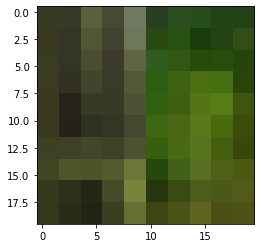

(20, 20, 3)


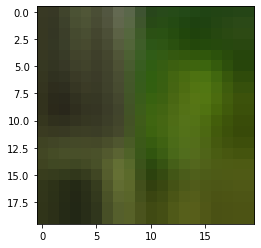

(40, 40, 3)


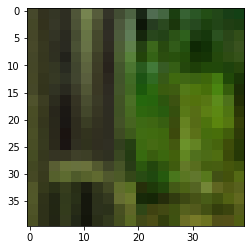

(40, 40, 3)


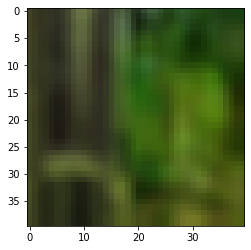

(80, 80, 3)


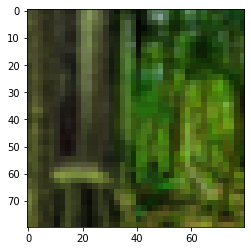

(80, 80, 3)


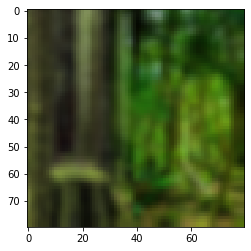

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(160, 160, 3)


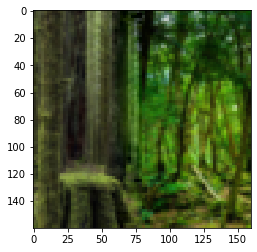

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(160, 160, 3)


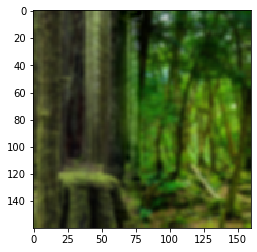

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(320, 320, 3)


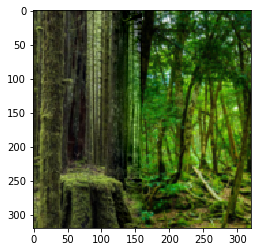

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(320, 320, 3)


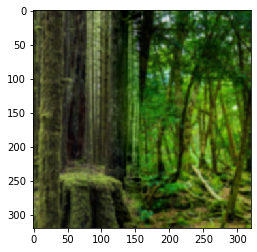

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(640, 640, 3)


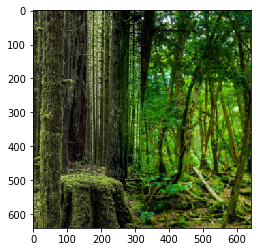

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(640, 640, 3)


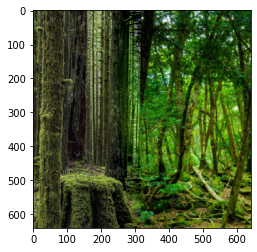

In [250]:
final = reconstruct(merge)

(640, 640, 3)


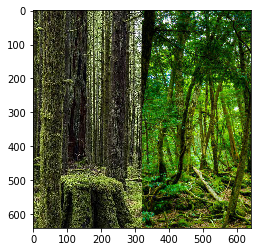

In [252]:
without_filter = np.hstack((pics[0][:,int(320):],pics[1][:,int(320):]))
display(without_filter)